<a href="https://colab.research.google.com/github/eedanileiko/Data-Analytics-Portfolio/blob/main/Linear_regressions_EDA_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение, ФКН ВШЭ

## Практическое домашнее задание 2. Градиентный спуск своими руками

### Общая информация

Дата выдачи: 30.09.2025

Мягкий дедлайн: 14.10.2025 23:59

Жесткий дедлайн: 18.10.2025 23:59


### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных модификаций градиентного спуска. В файле `descents.py` вам нужно будет реализовать несколько классов для различных вариаций градиентного спуска, а именно:
* `VanillaGradientDescent`
* `StochasticGradientDescent`
* `StochasticAverageGradient`
* `MomentumDescent`
* `Adam`

В файле `linear_regression.py` вам необходимо будет реализовать класс `LinearRegression` для обучения линейной регрессии (и, разумеется, предсказания целевой переменной на основе обученной модели).

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 11 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате **homework-practice-02-gd-Username.ipynb**, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 10

In [ ]:
import numpy as np
import numpy as np
from descents import BaseDescent
from dataclasses import dataclass
from enum import auto, Enum
from typing import Dict, Type, Optional
from scipy.sparse.linalg import svds
import numpy as np
from abc import ABC, abstractmethod

# ===== Learning Rate Schedules =====
class LearningRateSchedule(ABC):
    @abstractmethod
    def get_lr(self, iteration: int) -> float:
        pass


class ConstantLR(LearningRateSchedule):
    def __init__(self, lr: float):
        self.lr = lr

    def get_lr(self, iteration: int) -> float:
        return self.lr


class TimeDecayLR(LearningRateSchedule):
    def __init__(self, lambda_: float = 1.0):
        self.s0 = 1
        self.p = 0.5
        self.lambda_ = lambda_

    def get_lr(self, iteration: int) -> float:
        # TODO: реализовать формулу затухающего шага обучения
        self.lr=self.lambda_*(self.s0/(self.s0+iteration))**self.p
        return self.lr
       # raise NotImplementedError


# ===== Base Optimizer =====
class BaseDescent(ABC):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR):
        self.lr_schedule = lr_schedule()
        self.iteration = 0
        self.model = None

    def set_model(self, model):
        self.model = model

    @abstractmethod
    def update_weights(self):
        pass

    def step(self):
        dif=self.update_weights()
        self.iteration += 1
        return dif


# ===== Specific Optimizers =====
class VanillaGradientDescent(BaseDescent):
    def update_weights(self):
        # TODO: реализовать vanilla градиентный спуск
        # Можно использовать атрибуты класса self.model
        X_train = self.model.X_train
        y_train = self.model.y_train
        gradient = self.model.compute_gradients(X_train, y_train)
        d=-self.lr_schedule.get_lr(self.iteration)*gradient
        self.model.w+=d
        return d
        #raise NotImplementedError


class StochasticGradientDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR, batch_size=1):
        super().__init__(lr_schedule)
        self.batch_size = batch_size

    def update_weights(self):
        #raise NotImplementedError
        num_objects = self.model.X_train.shape[0]
        indec= np.random.choice(num_objects,size=self.batch_size,replace=False)
        X_batch=self.model.X_train[indec]
        y_batch=self.model.y_train[indec]
        gradient = self.model.compute_gradients(X_batch, y_batch)
        d=-self.lr_schedule.get_lr(self.iteration)*gradient
        self.model.w+=d
        return d
        # TODO: реализовать стохастический градиентный спуск
        # 1) выбрать случайный батч
        # 2) вычислить градиенты на батче
        # 3) обновить веса модели



class SAGDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR):
        super().__init__(lr_schedule)
        self.grad_memory = None
        self.grad_sum = None

    def update_weights(self):
        # TODO: реализовать SAG
        X_train = self.model.X_train
        y_train = self.model.y_train
        num_objects, num_features = X_train.shape

        if self.grad_memory is None:
            self.grad_memory=np.zeros((num_objects,num_features))
            self.grad_sum=np.zeros(num_features)
        j = np.random.randint(num_objects)
        new_grad = self.model.compute_gradients(X_train[j:j+1], y_train[j:j+1]).flatten()
        self.grad_sum += (new_grad - self.grad_memory[j])
        self.grad_memory[j] = new_grad.copy()

        lr=self.lr_schedule.get_lr(self.iteration)
        d=-lr*(self.grad_sum/num_objects)
        self.model.w+=d
        return d

        # TODO: реализовать SAG
       # raise NotImplementedError


class MomentumDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR, beta=0.9):
        super().__init__(lr_schedule)
        self.beta = beta
        self.velocity = None

    def update_weights(self):
        X_train=self.model.X_train
        y_train=self.model.y_train
        gradient = self.model.compute_gradients(X_train, y_train)
        if self.iteration==0:
            d=-self.lr_schedule.get_lr(self.iteration)*gradient
            self.velocity=-d.copy()
        else:
            d=-self.beta*self.velocity-self.lr_schedule.get_lr(self.iteration)*gradient
            self.velocity=-d.copy()
        self.model.w+=d
        return d


        # TODO: реализовать градиентный спуск с моментумом
        #raise NotImplementedError


class Adam(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(lr_schedule)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None
        self.v = None

    def update_weights(self):
        X_train=self.model.X_train
        y_train=self.model.y_train
        num_objects, num_features = X_train.shape
        gradient=self.model.compute_gradients(X_train,y_train)
        if self.m is None and self.v is None:
            self.m=np.zeros(num_features)
            self.v=np.zeros(num_features)
            self.m=self.beta1*self.m+(1-self.beta1)*gradient
            self.v=self.beta2*self.v+(1-self.beta2)*(gradient**2)
        else:
            self.m=self.beta1*self.m+(1-self.beta1)*gradient
            self.v=self.beta2*self.v+(1-self.beta2)*(gradient**2)
        lr=self.lr_schedule.get_lr(self.iteration)
        m_as=self.m/(1-(self.beta1**(self.iteration+1)))
        v_as=self.v/(1-(self.beta2**(self.iteration+1)))
        d=(-lr/(np.sqrt(v_as)+self.eps))*m_as
        self.model.w+=d
        return d


        # TODO: реализовать Adam по формуле из ноутбука
        #raise NotImplementedError



In [ ]:
import numpy as np
from descents import BaseDescent
from dataclasses import dataclass
from enum import auto, Enum
from typing import Dict, Type, Optional
from scipy.sparse.linalg import svds


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

class LinearRegression:
    def __init__(
        self,
        optimizer: Optional[BaseDescent | str] = None,
        l2_coef: float = 0.0,
        tolerance: float = 1e-6,
        max_iter: int = 1000,
        loss_function: LossFunction = LossFunction.MSE
    ):
        self.optimizer = optimizer
        if isinstance(optimizer, BaseDescent):
            self.optimizer.set_model(self)
        self.l2_coef = l2_coef
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss_function = loss_function
        self.w = None
        self.X_train = None
        self.y_train = None
        self.loss_history = []

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.w is None:
            raise NotImplementedError("predict function is not implemented")
        return X@self.w


    def compute_gradients(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            # TODO: реализовать вычисление градиентов для MSE
            grad=(2/y.shape[0])*X.T@(X @ self.w-y)
            reg = self.l2_coef * self.w
            reg[-1]=0
            grad+=self.l2_coef*self.w

           # raise NotImplementedError("MSE gradients is not implemented")
        elif self.loss_function is LossFunction.MAE:
            grad=X.T@np.sign(X @ self.w-y)/y.shape[0]
            if self.l2_coef>0:
                grad+=2*self.l2_coef*self.w

        elif self.loss_function is LossFunction.LogCosh:
            grad=X.T@np.tanh(error)

        elif self.loss_function is LossFunction.Huber:
            delta = 1
            c = np.where(np.abs(X @ self.w - y) < delta, error, delta * np.sign(error))
            grad=(1/num_objects)*X.T@c

        else:
            raise NotImplementedError("MSE gradients is not implemented")

        return grad

    def compute_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        if self.loss_function is LossFunction.MSE:
            loss=np.mean((X@self.w-y)**2)+self.l2_coef * np.sum(self.w[::-1]**2)

        elif self.loss_function is LossFunction.MAE:
            loss=np.mean(abs(X@self.w-y))

        elif self.loss_function is LossFunction.LogCosh:
            loss= np.mean(np.log(np.cosh(error)))

        elif self.loss_function is LossFunction.Huber:
            delta = 1
            loss1 = np.where(
                np.abs(error) < delta,
                error**2 / 2,
                delta * np.abs(error) - delta**2 / 2
            )
            loss=np.mean(loss1)

        else:
            raise NotImplementedError("MSE is not implemented")
        return loss

    def fit(self, X: np.ndarray, y: np.ndarray):
        # TODO: реализовать обучение модели
        self.X_train, self.y_train = X, y
        n_features= X.shape[1]
        self.w=np.zeros(n_features)
        self.loss_history.append(self.compute_loss(X,y))
        if isinstance(self.optimizer, BaseDescent):
            for _ in range(self.max_iter):
                d=self.optimizer.step()
                self.loss_history.append(self.compute_loss(X,y))
                self.w+=d
                if (np.sum(d**2) < self.tolerance) or np.isnan(d).any() or np.isnan(self.w).any():
                    break

        elif self.optimizer == "SVD":
            U, s, VT = svds(X, k=4)
            s_inv = np.linalg.inv(np.diag(s))
            self.w = VT.T @ s_inv @ U.T @ y
            #self.loss_history.append(self.compute_loss(X, y))
        else:
            self.w = (np.linalg.inv(self.X_train.T @ self.X_train) @ self.X_train.T @ self.y_train)


                # 1 шаг градиентного спуска

        # elif self.optimizer is ...
        #raise NotImplementedError("Linear Regression training is not implemented")




## Задание 1. Реализация градиентного спуска (4 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Напоминание про градиентный спуск

Основное свойство антиградиента &ndash; он указывает в сторону *наискорейшего* убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь $\eta_{k}$ обозначает длину шага на $k$-ой итерации (learning rate), а $Q(w)$ - функцию потерь (loss function).

### Градиент функции потерь MSE

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2025-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0.02 балла).

Напомним, что функция потерь MSE записывается как:

$$
    Q(w) = \frac{1}{\ell} \sum \limits_{i = 1}^\ell (y_i - \langle x_i, w \rangle)^2 = \frac{1}{\ell} \| X w - y \|^2
$$

где $\ell$ – количество объектов в выборке, $X \in \mathbb{R}^{\ell \times d}$ – матрица "объект-признак", а $y \in \mathbb{R}^\ell$ – целевая переменная. Через $x_i$ обозначается $i$-ая строчка матрицы $X$, отвечающая за $i$-й объект выборки.

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

**Решение:**

<font color='blue'>$$\nabla Q(w) = 2X^T(Xw - y).$$</font>

### Задание 1.1. Learning Rate Schedules (0.03 балла)

Обратите внимание на **абстрактный** класс `LearningRateSchedule` в файле `descents.py`. С помощью него мы на каждой итерации градиентного спуска будем получать соответствующий `learning_rate` $\eta_k$.

В файле уже реализован класс `ConstantLR`, который на каждой итерации возвращает один и тот же заранее заданный шаг. Ваша задача в этом пункте – реализовать `TimeDecayLR`, который мы будем использовать для обучения линейной регрессии. Формула очередного шага должна выглядеть следующим образом:
$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

**Обратите внимание**

Все реализуемые вами классы спуска в задании - это *универсальные* оптимизаторы. Они не должны считать градиенты конкретной функции потерь внутри себя.

Для вычисления градиента они всегда обращаются к модели, с которой работают:

```
gradient = self.model.compute_gradients(X_batch, y_batch)
```

Чтобы это работало, уже на данном этапе должны быть реализованы в `linear_regression.py`:

* `compute_gradients(X, y)` для MSE (в дальнейшем, в Задании 7, сюда добавляется член L2-регуляризации),
* `compute_loss(X, y)` для MSE (аналогично с учётом L2 при необходимости).

Если идёте строго по порядку, реализуйте эти MSE-версии в начале Задания 2.1 (используя формулы из п. 1.0), а затем вернитесь к заданиям 1.2–1.6 - код оптимизаторов менять не придётся. В Задании 8 вы просто расширите обе функции под `LogCosh` и `Huber`, переключая их через `self.loss_function`.

Такой подход позволяет свободно менять функцию потерь, не переписывая алгоритмы оптимизации.

### Задание-примечание 1.1. Родительский класс BaseDescent (0 баллов).

В файле `descents.py` приведен шаблон класса `BaseDescent` – родительского класса для модификаций градиентного спуска, от которого будут наследоваться другие классы (`VanillaGradientDescent`, `StochasticGradientDescent`, `MomentumDescent` и `Adam`). Более подробно про наследование классов в Python можно прочитать
* Наследование: https://docs.python.org/3/tutorial/classes.html#inheritance
* Абстрактные классы: https://docs.python.org/3/library/abc.html

В классе `BaseDescent` **все методы уже реализованы**. Цель этого задания – внимательно ознакомиться с тем, как устроен этот класс.

Обратите внимание на атрибут `self.iteration`, отвечающий за номер итерации алгоритма спуска. Как раз с помощью него (и `self.lr_schedule`) мы и будем получать `learning_rate` на соответствующей итерации алгоритма. Функция `update_weights` должна обновлять веса модели `self.model.w`, а также возвращать величину обновления $w_{k + 1} - w_k$

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Напомним, что шаг классического градиентного спуска выглядит следующим образом:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

**Важно**: Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$. Кроме того, соответственно своему названию, она должна обновлять веса модели `model.w`.

### Напоминание про SGD (стохастических градиентный спуск)

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов, обычно называемое **батчом**.

Оценка $\frac{1}{|B|} \sum \limits_{i \in B} \nabla_w q_i(w_k)$ называется **стохастическим градиентом** функции потерь, а получившийся метод называют методом **стохастического градиентного спуска** или просто SGD.

### Задание 1.3. Стохастический градиентный спуск StochasticGradientDescent (0.7 баллов).

Реализуйте стохастический градиентный спуск, заполнив пропуски в классе `StochasticGradientDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться **гиперпараметром** метода и передаваться в конструктор класса `__init__(...)`. Семплировать индексы батча объектов $B$ можно с повторениями (через np.random.randint) - это допустимо и даёт несмещённую оценку градиента. По желанию можно без повторений (np.random.choice(..., replace=False) или через пермутацию по эпохам).

### Напоминание про метод инерции (или метод моментов)

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация (например, в случае **стохастического градиентного спуска**). Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Stochastic Average Gradient (0.45 балла)

Держим память последних индивидуальных градиентов $g_i$ по всем объектам и их среднее $\bar g = \frac{1}{\ell}\sum_i g_i$. На каждом шаге выбираем индекс(ы) $j$ (мини-батч), заново считаем $g_j^{new}(w_k)$, обновляем среднее:
$$
\bar g \leftarrow \bar g + \frac{1}{\ell}\bigl(g_j^{new} - g_j^{old}\bigr),\qquad
w_{k+1} = w_k - \eta_k, \bar g.
$$
Инициализация: $g_i=0 \Rightarrow \bar g=0$.

Так получаем шаг почти как у полного градиента, но считаем градиент лишь на одном (или нескольких) объекте за итерацию.

Реализуйте класс `SAG` в `descents.py` с хранением `grad_memory` и `avg_grad`. Подсказка: чтобы получить пер-объектный градиент, можно вызывать `compute_gradients` на срезе из одного объекта `X[j:j+1]`.


### Задание 1.5 Метод Momentum - MomentumDescent (0.8 баллов).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ являеться гиперпараметром метода, однако в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

### Напоминание про AdaGrad, RMSprop и Adam

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. Идея проста: мы будем "копить" сумму квадратов градиентов и делить очередной градиент на корень из этой суммы. Таким образом, обновление весов с большими градиентами будет тормозиться, а с маленькими наоборот получать большие шаги. Формула обновлени будет выглядить так:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафиксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения **(обратите внимание, что в данном домашнем задании длина шага не фиксируется)**. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций (метод инерции), а также делать адаптивную длину шага по каждому параметру (`RMSProp`). Таким образом, мы получим метод `Adam` с той лишь разницей, что в методе `Adam` дополнительно делается нормировка накопленных градиентов и квадратов градиентов для устранения смещения.

### Задание 1.6. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

Реализуйте градиентный спуск с методом Adam, заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

## Задание 2. Линейная регресия (1 балл)

### Задание 2.1. Решение методом градиентного спуска (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegressionModel**. По сути линейная регрессия будет оберткой, которая запускает обучение

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Веса модели надо обновлять внутри функции `update_weights`, она неспроста так называется
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

### Задание 2.2. Аналитическое решение (0.5 балла)

Но, как мы помним из лекции, помимо решения при помощи градиентного спуска, для ряда функций потерь можно выписать в том числе аналитическое решение. Давайте сперва вспомним, как оно выглядит для MSE. Выведите оптимальную формулу для $w$, держа в памяти формулу MSE, и дополните класс `LinearRegression`

$$\text{MSE} = \| X w - y \|^2$$
<font color='blue'>$$w = (X^TX)^{-1}X^Ty$$</font>


**Вопрос**: Как мы помним, у аналитического решения есть минусы, какие кстати?

**Ответ**: <font color='blue'>В формуле присутствует обращение матрицы $X^TX$ —  трудоёмкая операция при большом количестве признаков, плюс матрица может быть необратима. Чтобы облегчить сложность и используют градиентный спуск.</font>

Тут мы ничего специально проверять в контесте не будем

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
from linear_regression import LinearRegression

num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [ ]:
from sklearn import linear_model

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import sklearn

sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LinearRegression(optimizer=None)
your_linreg.fit(x, y)
print("Your MSE", mse(your_linreg.predict(x), y))

assert abs(mse(your_linreg.predict(x), y) - mse(sklearn_linreg.predict(x), y)) < 1e-12, "Не повезло, попробуйте еще раз"

Sklearn MSE 0.08790632411599077
Your MSE 0.08790632411599077


Давайте сделаем задание немного прикольнее и изменим одну из колонок. Как мы знаем, полная мультиколлинеарность запрещает нам пользоваться аналитическим решением, но `sklearn` по какой-то причине это обходит, хмм

In [ ]:
x[:, 3] = x[:, 2] + x[:, 4]

In [ ]:
sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg =LinearRegression(optimizer=None)
your_linreg.fit(x, y)

print("Your MSE", mse(your_linreg.predict(x), y))

Sklearn MSE 0.08820506336554386
Your MSE 0.09299774566792875


Ваша задача - понять, как можно сделать так, чтобы аналитическое решение работало всегда, вне зависимости от матрицы X. Как оказывается, это можно сделать, если воспользоваться SVD разложением, в нашем случае усеченным, чтобы было проще (это не то же самое, что обычный SVD, у него другие размерности матриц, смотрите ниже). Воспользуйтесь `scipy.sparse.linalg.svds` с числом компонент 4

Выведите формулу для w и снова дополните класс `LinearRegression`

$$\text{X} = \underset{n\times m}{\mathrm{U}} \ \underset{m\times m}{\mathrm{\Sigma}} \ \underset{m\times k}{\mathrm{V^T}}$$
$$ w = $$

In [ ]:
sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LinearRegression(optimizer="SVD")
your_linreg.fit(x, y)
print("Your MSE", mse(your_linreg.predict(x), y))

assert abs(mse(your_linreg.predict(x), y) - mse(sklearn_linreg.predict(x), y)) < 1e-12, "Не повезло, попробуйте еще раз"

Sklearn MSE 0.08820506336554386
Your MSE 0.08820506336554385


## Задание 3. Проверка кода (0 баллов)

Данная секция нужна для того, чтобы убедиться в правильности реализации методов спуска и класса `LinearRegression`. В начале мы сделаем небольшую локальную проверку на "адекватность" и "запускаемость" ваших моделей, после чего уже можно будет делать посылки в Яндекс Контест.

In [ ]:
%load_ext autoreload

In [ ]:
#%autoreload 2

from descents import (
    VanillaGradientDescent,
    StochasticGradientDescent,
    SAGDescent,
    MomentumDescent,
    Adam
)

In [ ]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

Проверяем код на запускаемость.

In [ ]:
# Если вы реализовали не все методы спуска, то уберите лишние из списка ниже
descent_models = [
    VanillaGradientDescent,
    StochasticGradientDescent,
    SAGDescent,
    MomentumDescent,
    Adam
]
from linear_regression import LinearRegression

max_iter = 10
tolerance = 0
num_objects = 100
dimension = 5

for descent_model in descent_models:
    optimizer = descent_model()
    model = LinearRegression(
        optimizer=optimizer,
        tolerance=tolerance,
        max_iter=max_iter,
    )
    model.fit(x, y)
    assert len(model.loss_history) == max_iter + 1, "Loss history failed"
    y_pred = model.predict(x)
    assert y_pred.shape == y.shape, "Prediction shape does not match target variable"

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в Яндекс Контесте (чуть позже скинем ссылку).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**: https://new.contest.yandex.ru/contests/82854/problem?id=9236982%2F2025_10_10%2FmQZqTbOY85&tab=submissions&submissionId=10000068-f12f-60c6-90f9-21ae8c9f833f


* **StochasticDescent**: https://new.contest.yandex.ru/contests/82854/problem?id=9236982%2F2025_10_12%2F5uRhSAMSnW&tab=submissions&submissionId=10000068-ee7c-c52f-4517-6d79fdecf655


* **SAGDescent**: https://new.contest.yandex.ru/contests/82854/problem?id=9236982%2F2025_10_12%2FzVG9mQzDO4&tab=submissions&submissionId=10000068-eec3-a0f5-a18c-181a3739cc04


* **MomentumDescent**: https://new.contest.yandex.ru/contests/82854/problem?id=9236982%2F2025_10_12%2FNFCAaeBVfC&tab=submissions&submissionId=10000068-eecb-1c41-ba7b-d876c740c660


* **Adam**: https://new.contest.yandex.ru/contests/82854/problem?id=9236982%2F2025_10_12%2FB1lQ7NjGgz&tab=submissions&submissionId=10000068-eed5-4506-f720-de0abdb43f13


* **LinearRegression**: https://new.contest.yandex.ru/contests/82854/problem?id=9236982%2F2025_10_12%2F6PSKLrmgx8&tab=submissions&submissionId=10000068-f12f-51f7-fc9f-d8d394268b50

На всякий случай ссылка на ID

VanillaGradientDescent: ID 145436234

StochasticDescent: ID 145099196

SAGDescent: ID 145136439

MomentumDescent: ID 145137778

Adam: ID 145138963

LinearRegression: ID 145436195

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте (и напишите): какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте (и напишите): какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [ ]:
import numpy as np
import pandas as pd  # при желании, можете заменить на polars/pyspark или что угодно, что вам нравится

import matplotlib.pyplot as plt
import seaborn as sns

from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent
)
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [ ]:
data = pd.read_csv('autos.csv')  # разумеется, если вы используете не pandas, это надо поменять

In [ ]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [ ]:
data.describe()

,powerPS,kilometer,autoAgeMonths,price
count,241190.000000,241190.000000,241190.000000,241190.000000
mean,131.271628,123766.677723,144.768676,6887.741892
std,60.622613,39825.955933,73.092598,8024.451993
min,51.000000,5000.000000,1.000000,1.000000
25%,90.000000,100000.000000,92.000000,1750.000000
50%,120.000000,150000.000000,140.000000,4100.000000
75%,160.000000,150000.000000,192.000000,8999.000000
max,589.000000,150000.000000,600.000000,99999.000000


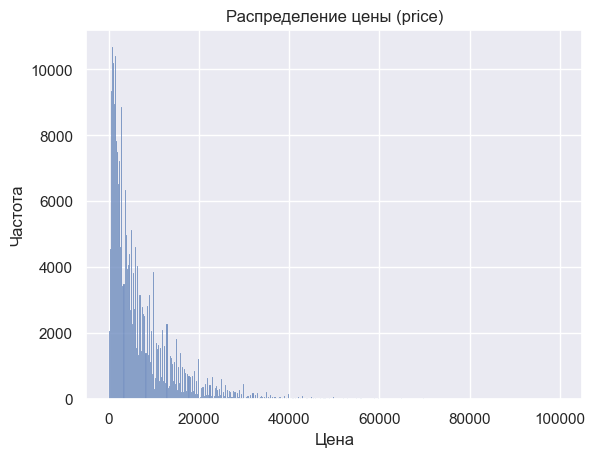

In [ ]:
sns.histplot(data['price'])
plt.title('Распределение цены (price)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()
plt.show()

<font color='blue'>Видим, что график уходит вправо, моежем логарифмировать данные, что распределение данных было больше похоже на нормальное</font>

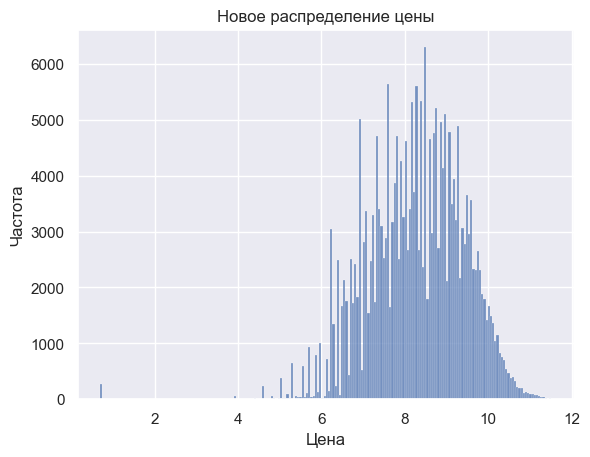

In [ ]:
data['price1'] = np.log1p(data['price'])
sns.histplot(data['price1'])
plt.title('Новое распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

<font color='blue'>Теперь легче анализировать данные дальше</font>

<font color='blue'>Теперь удалим выбросы.</font>

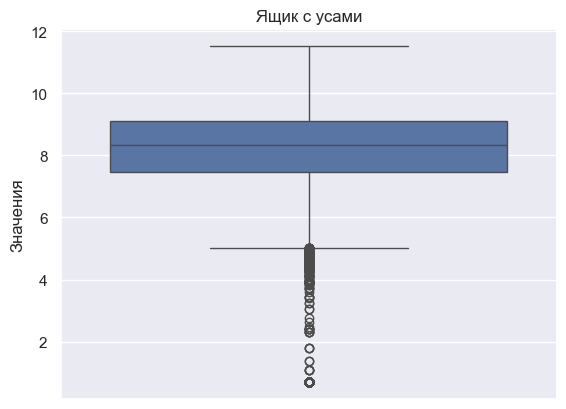

In [ ]:
sns.boxplot(data['price1'])
plt.ylabel('Значения')
plt.title('Ящик с усами')
plt.show()

<font color='blue'>Это наше до</font>

In [ ]:
Q1 = data['price1'].quantile(0.25)
Q3 = data['price1'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data = data[(data['price1'] >= lower) & (data['price1'] <= upper)].copy()
data['price'] = np.log(data['price'] + 1)
data['autoAgeMonths'] = np.log(data['autoAgeMonths'] + 1)
data['powerPS'] = np.log(data['powerPS'] + 1)

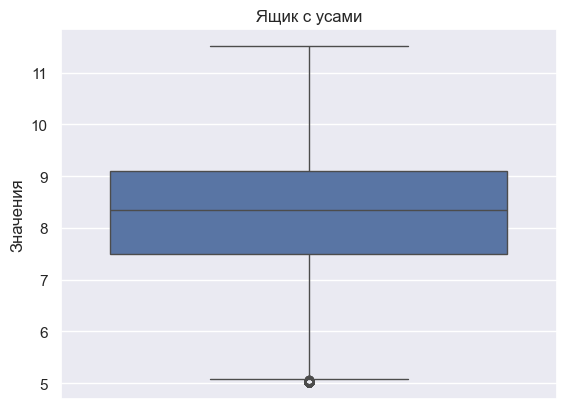

In [ ]:
sns.boxplot(data['price1'])
plt.ylabel('Значения')
plt.title('Ящик с усами')
plt.show()

<font color='blue'>Это после)</font>

<font color='blue'>Теперь давайте посмотим на корреляцию!</font>

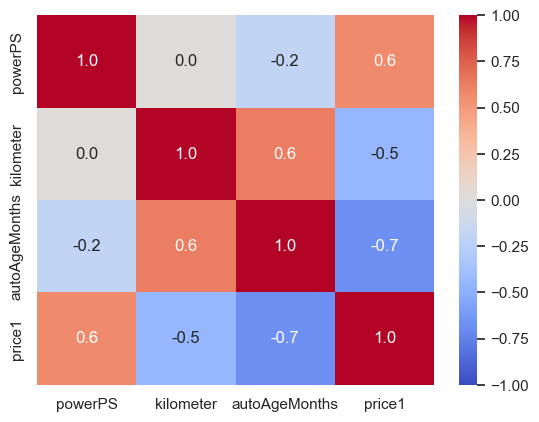

In [ ]:
sns.heatmap(data[['powerPS','kilometer','autoAgeMonths','price1']].corr(numeric_only=True), annot=True, fmt = '0.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.show()

In [ ]:
data = data.drop(['brand', 'kilometer'], axis=1)

<font color='blue'>Можем заметить, что каждый набор данных неплохо коррелирует с ценой, самая маленькая по модулю корреляция у километража</font>

Разделите признаки на категориальные, числовые и ... все остальное

In [ ]:
data.dtypes

model                 object
vehicleType           object
gearbox               object
fuelType              object
notRepairedDamage     object
powerPS              float64
autoAgeMonths        float64
price                float64
price1               float64
dtype: object

In [ ]:
data['price']=data['price1']
data=data.drop(['price1'],axis=1)
categorical = list(data.dtypes[data.dtypes=='object'].index)
numeric = list(data.dtypes[data.dtypes=='int64'].index)
other = []

Добавляем в данные единичную колонку `bias`, чтобы не делать отдельные параметр $b$ для свободного члена модели.

In [ ]:
data['bias'] = 1
other += ['bias']

x = data[categorical + numeric + other]
y = data['price']

In [ ]:
data.head()

,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,autoAgeMonths,price,bias
0,golf,kleinwagen,manuell,benzin,nein,4.330733,5.181784,7.313887,1
1,fabia,kleinwagen,manuell,diesel,nein,4.248495,4.543295,8.188967,1
2,3er,limousine,manuell,benzin,ja,4.634729,5.509388,6.478510,1
3,2_reihe,cabrio,manuell,benzin,nein,4.700480,4.948760,7.696667,1
4,3_reihe,limousine,manuell,benzin,nein,4.663439,4.919981,7.601402,1


А также сделаем базовую обработку данных, а именно:
* Применим `OneHotEncoding` к категориальным признакам
* Стандартизуем численные признаки с помощью `StandardScaler`
* Остальные признаки трогать не будем, т.к. с ними непонятно что делать

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)

Теперь вам необходимо разбить данные на обучающую, тестовую и валидационную выборки:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Потом temp делим пополам на val и test
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)
print(x_train.shape, x_val.shape, x_test.shape)

scaler = StandardScaler(with_mean=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


(192319, 269) (24040, 269) (24040, 269)


## Задание 5. Сравнение методов градиентного спуска (1.5 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (0.75 балла)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [ ]:
# YOUR CODE
from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent)
from linear_regression import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lambda_arr= np.logspace(-5, -2, 3)
loss_storage_val=[]
Optimizers=[VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent]
bests_lambdas=[]
bests_losses=[]
loss_storage_train=[]

k=0
for optim in Optimizers:
    best_loss=-10**10
    best_lambda=None
    for lambda_1 in lambda_arr:

        optimizer = optim(lr_schedule=lambda: ConstantLR(lambda_1))
        model = LinearRegression(
                optimizer=optimizer,
                l2_coef=0.0,
                tolerance=1e-6,
                max_iter=2000
            )
        model.fit(x_train,y_train)
        y_pred_val= model.predict(x_val)
        history=model.loss_history.copy()
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        loss_val=r2_score(y_val, y_pred_val)
        if loss_val>best_loss:
            best_loss=loss_val
            best_lambda=lambda_1
        loss_train=r2_score(y_train, y_train_pred)
        loss_test=r2_score(y_test, y_test_pred)
    if k==0:
        Vanilla_history=history
    elif k==1:
        SGD_history=history
    elif k==2:
        Momentum_history=history
    elif k==3:
        Adam_history=history
    else:
        SAGD_history=history
    k+=1

    print('Optimazer == '+str(optim)+' Best loss is '+str(best_loss)+' Best lambda is '+str(best_lambda))
    bests_lambdas.append(best_lambda)
    bests_losses.append(best_loss)

Optimazer == <class 'descents.VanillaGradientDescent'> Best loss is -20.641430114809967 Best lambda is 0.01
Optimazer == <class 'descents.StochasticGradientDescent'> Best loss is -25.91767692153208 Best lambda is 0.00031622776601683794
Optimazer == <class 'descents.MomentumDescent'> Best loss is -20.467571516262556 Best lambda is 0.01
Optimazer == <class 'descents.Adam'> Best loss is -25.296055160659918 Best lambda is 0.01
Optimazer == <class 'descents.SAGDescent'> Best loss is -55.32139514704919 Best lambda is 0.01


### Задание 5.2. Сравнение методов (0.75 балла)

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

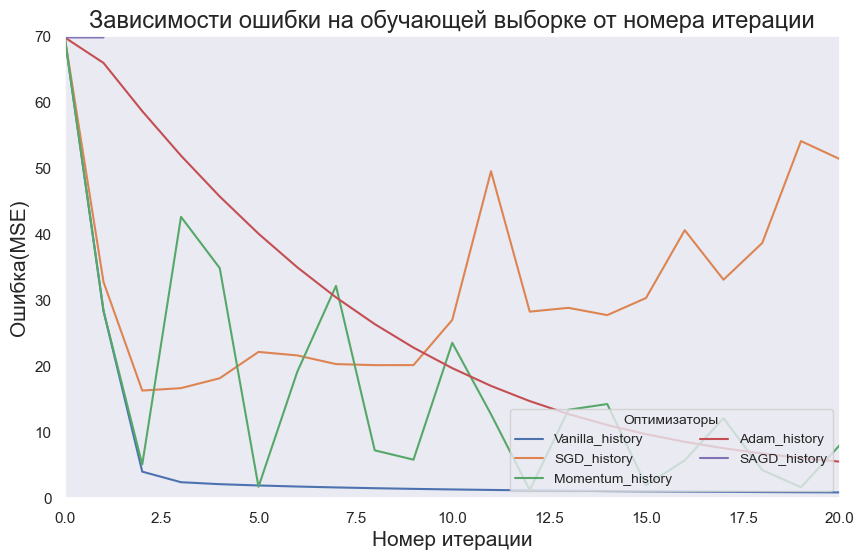

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(Vanilla_history, label='Vanilla_history')
plt.plot(SGD_history, label='SGD_history')
plt.plot(Momentum_history, label='Momentum_history')
plt.plot(Adam_history, label='Adam_history')
plt.plot(SAGD_history, label='SAGD_history')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости ошибки на обучающей выборке от номера итерации', fontsize=17)
plt.ylabel('Ошибка(MSE)', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()
plt.show()

<font color='blue'>**Vanilla Gradient Descent** демонстрирует самую быструю начальную сходимость, но иногда застревает</font> \
<font color='blue'>**SGD и SAGD** показывают нестабильное поведение с колебаниями ошибки (возможно из-за неподходящего набора параметров)</font>\
<font color='blue'>**Adam** самый плавный, обеспечивает более стабильную и плавную сходимость, что делает его хорошим выбором по умолчанию</font>\
<font color='blue'>**Momentum** показывает очень медленную сходимость, ходит туда-сюда</font>

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска.

* Сделайте по несколько запусков (например, $k = 10$) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча. _(под сходимостью понимается достижение критерия останова)_
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [ ]:
# YOUR CODE
from descents import StochasticGradientDescent, TimeDecayLR
from linear_regression import LinearRegression
import time
batch_sizes = [1, 10, 50, 100, 500, 1000]
k = 10
max_iter = 1000
tolerance = 1e-6
results = {}
for batch_size in batch_sizes:
    results[batch_size] = {
        "iterations": [],
        "time": []
    }
    for i in range(k):
        start_time = time.time()
        optimizer = StochasticGradientDescent(lr_schedule=lambda: ConstantLR(0.00031622776601683794), batch_size=batch_size)
        model = LinearRegression(optimizer=optimizer, tolerance=tolerance, max_iter=max_iter)
        model.fit(x_train, y_train)
        end_time = time.time()
        results[batch_size]["iterations"].append(len(model.loss_history) - 1)
        results[batch_size]["time"].append(end_time-start_time)

mean_iterations = {batch_size:np.mean(results[batch_size]["iterations"]) for batch_size in batch_sizes}
mean_time = {batch_size:np.mean(results[batch_size]["time"]) for batch_size in batch_sizes}

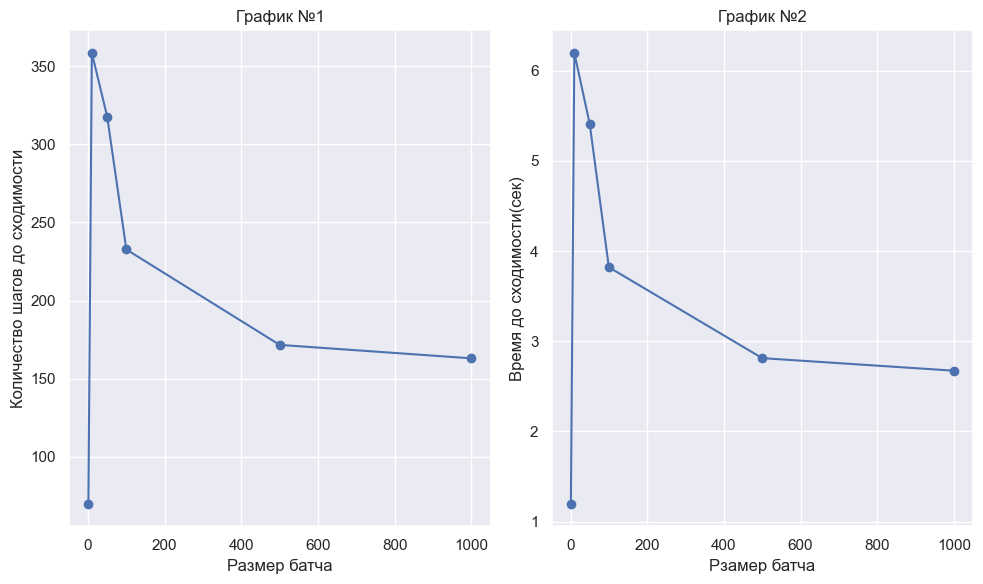

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(mean_iterations.keys(), mean_iterations.values(), marker='o')
plt.xlabel("Размер батча")
plt.ylabel("Количество шагов до сходимости")
plt.title("График №1")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mean_time.keys(), mean_time.values(), marker='o')
plt.xlabel("Рзамер батча")
plt.ylabel("Время до сходимости(сек)")
plt.title("График №2")
plt.grid(True)

plt.tight_layout()
plt.show()

**Выводы:**
<font color='blue'>При увеличении размера батча время до сходимости резко снижается, так как уменьшается количество итераций. При маленьких размерах батча количество итераций до сходимости выше,потому что градиент, оцененный на малом батче, шумный, поэтому к миимуму идет плохо.</font>

## Задание 7. Регуляризация (0.5 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация – это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать $L_2$-регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 5 графиков).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [ ]:
# YOUR CODE
# YOUR CODE
from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent)
from linear_regression import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lambda_arr= np.logspace(-5, -2, 4)
mu_arr= np.logspace(-5, -2, 4)
loss_storage_val=[]
Optimizers=[VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent]
bests_lambdas=[]
bests_losses=[]
loss_storage_train=[]
bests_mus=[]
k=0
for optim in Optimizers:
    best_loss=-10**10
    best_lambda=None
    for lambda_1 in lambda_arr:
        for mu in mu_arr:

            optimizer = optim(lr_schedule=lambda: ConstantLR(lambda_1))
            model = LinearRegression(
                    optimizer=optimizer,
                    l2_coef=mu,
                    tolerance=1e-6,
                    max_iter=2000
                )
            model.fit(x_train,y_train)
            y_pred_val= model.predict(x_val)
            history=model.loss_history.copy()
            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            loss_val=r2_score(y_val, y_pred_val)
            if loss_val>best_loss:
                best_loss=loss_val
                best_lambda=lambda_1
                best_mu=mu
            loss_train=r2_score(y_train, y_train_pred)
            loss_test=r2_score(y_test, y_test_pred)
    if k==0:
        Vanilla_history=history
    elif k==1:
        SGD_history=history
    elif k==2:
        Momentum_history=history
    elif k==3:
        Adam_history=history
    else:
        SAGD_history=history
    k+=1

    print('Optimazer == '+str(optim)+' Best loss is '+str(best_loss)+' Best lambda is '+str(best_lambda)+' Best mu is '+str(best_mu))
    bests_lambdas.append(best_lambda)
    bests_mus.append(mu)
    bests_losses.append(best_loss)

Optimazer == <class 'descents.VanillaGradientDescent'> Best loss is -20.641442014015677 Best lambda is 0.01 Best mu is 1e-05
Optimazer == <class 'descents.StochasticGradientDescent'> Best loss is -22.62988594184263 Best lambda is 0.001 Best mu is 0.001
Optimazer == <class 'descents.MomentumDescent'> Best loss is -20.467584930535942 Best lambda is 0.01 Best mu is 1e-05
Optimazer == <class 'descents.Adam'> Best loss is -25.17909131383417 Best lambda is 0.01 Best mu is 0.01
Optimazer == <class 'descents.SAGDescent'> Best loss is -55.3214097013234 Best lambda is 0.01 Best mu is 0.0001


In [ ]:
bests_lambdas=[1e-05,0.001,1e-05,0.01,0.0001]

In [ ]:
from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent)
from linear_regression import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lambda_arr= np.logspace(-5, -2, 4)
mu_arr= np.logspace(-5, -2, 4)
loss_storage_val=[]
Optimizers=[VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent]
loss_storage_train=[]
k=0
for optim in Optimizers:
    lambda_1=bests_lambdas[k]
    #best_loss=-10**10
    #best_lambda=None
    optimizer = optim(lr_schedule=lambda: ConstantLR(lambda_1))
    model = LinearRegression(
            optimizer=optimizer,
            l2_coef=0.0,
            tolerance=1e-6,
            max_iter=2000
        )
    model.fit(x_train,y_train)
    y_pred_val= model.predict(x_val)
    history=model.loss_history.copy()
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    loss_val=r2_score(y_val, y_pred_val)
    loss_train=r2_score(y_train, y_train_pred)
    loss_test=r2_score(y_test, y_test_pred)
    if k==0:
        Vanilla_history1=history
    elif k==1:
        SGD_history1=history
    elif k==2:
        Momentum_history1=history
    elif k==3:
        Adam_history1=history
    else:
        SAGD_history1=history
    k+=1

    print('Optimazer == '+str(optim)+'loss is '+str(loss_val)+' Best lambda is '+str(lambda_1))
    #bests_lambdas.append(best_lambda)
    #bests_mus.append(mu)
    #bests_losses.append(best_loss)

Optimazer == <class 'descents.VanillaGradientDescent'>loss is -55.290539075680535 Best lambda is 1e-05
Optimazer == <class 'descents.StochasticGradientDescent'>loss is -22.215468337205014 Best lambda is 0.001
Optimazer == <class 'descents.MomentumDescent'>loss is -55.290539075680535 Best lambda is 1e-05
Optimazer == <class 'descents.Adam'>loss is -25.296055160659918 Best lambda is 0.01
Optimazer == <class 'descents.SAGDescent'>loss is -55.3215856281898 Best lambda is 0.0001


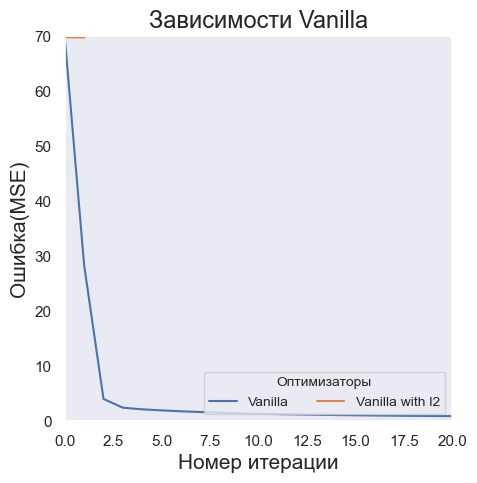

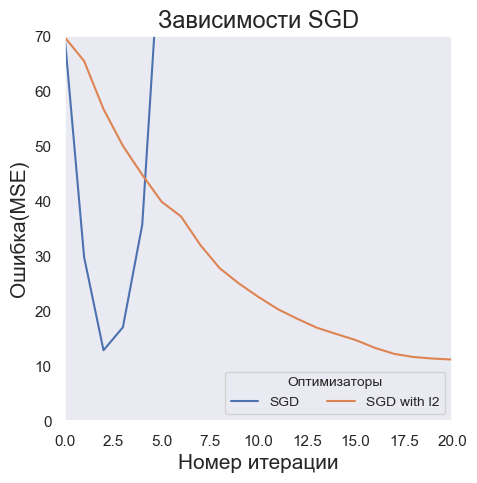

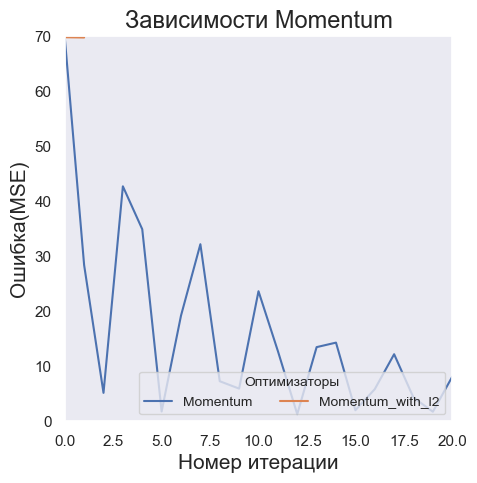

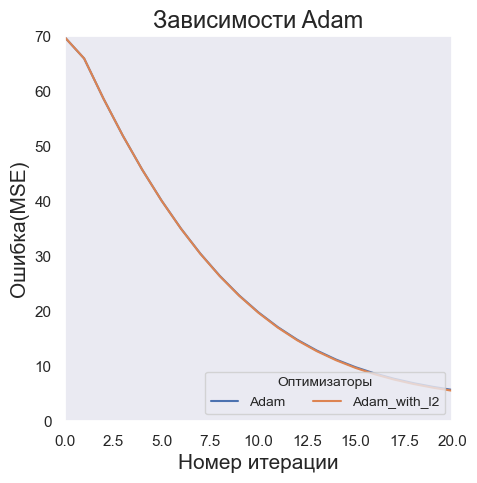

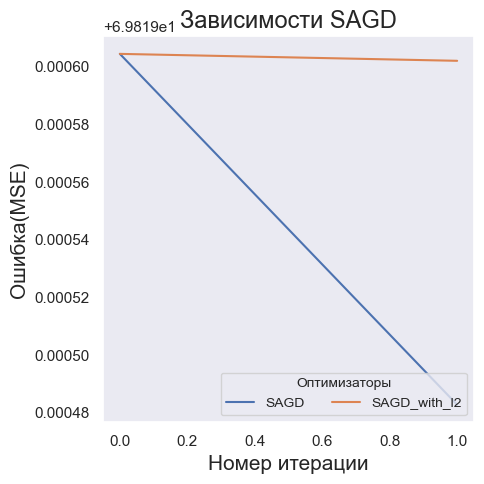

In [ ]:
plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 1)
plt.plot(Vanilla_history, label='Vanilla')
plt.plot(Vanilla_history1, label='Vanilla with l2')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Vanilla', fontsize=17)
plt.ylabel('Ошибка(MSE)', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 10))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()


plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 2)
plt.plot(SGD_history, label='SGD')
plt.plot(SGD_history1, label='SGD with l2')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости SGD', fontsize=17)
plt.ylabel('Ошибка(MSE)', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 3)
plt.plot(Momentum_history, label='Momentum')
plt.plot(Momentum_history1, label='Momentum_with_l2')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Momentum', fontsize=17)
plt.ylabel('Ошибка(MSE)', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 4)
plt.plot(Adam_history, label='Adam')
plt.plot(Adam_history1, label='Adam_with_l2')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Adam', fontsize=17)
plt.ylabel('Ошибка(MSE)', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 5)
plt.plot(SAGD_history, label='SAGD')
plt.plot(SAGD_history1, label='SAGD_with_l2')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости SAGD', fontsize=17)
plt.xlabel('Номер итерации', fontsize=15)
plt.ylabel('Ошибка(MSE)', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
#plt.xlim(0, 20)
#plt.ylim(0, 70)
plt.grid()


plt.tight_layout()
plt.show()

**Вывод:**

<font color='blue'>L2-регуляризация помогает улучшить сходимость и избежать переобучения.</font>

## Задание 8. Альтернативные функции потерь (1 балл)

В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **LogCosh** и **HuberLoss**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$

$$
L_{\text{Huber}}(y, a) = \frac{1}{n} \sum_{i=1}^{n}
\begin{cases}
   \frac{1}{2} (a_i - y_i)^2, & \text{если } |a_i - y_i| < \delta, \\
   \delta \cdot |a_i - y_i| - \frac{1}{2} \delta^2, & \text{если } |a_i - y_i| \geq \delta,
\end{cases}
$$

Самостоятельно продифференцируйте данные функции потерь чтобы найти их градиенты _(требуется показать не только результат, но и промежуточные вычисления)_:

**Решение:**

`### Ваше решение тут ###`

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class LinearRegression:
    def __init__(
        self,
        optimizer: BaseDescent,
        l2_coef: float = 0.0,
        tolerance: float = 1e-6,
        max_iter: int = 1000,
        loss_function: LossFunction = LossFunction.MSE
    ):
        ...
    
    def compute_gradients(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            # YOUR CODE FOR MSE
        if self.loss_function is LossFunction.MAE:
            # YOUR CODE FOR MAE
        ...
    
    def compute_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        if self.loss_function is LossFunction.MSE:
            # YOUR CODE FOR MSE
        if self.loss_function is LossFunction.MAE:
            # YOUR CODE FOR MAE
        ...
...

```

In [ ]:
import numpy as np
from descents import BaseDescent
from dataclasses import dataclass
from enum import auto, Enum
from typing import Dict, Type, Optional
from scipy.sparse.linalg import svds


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

class LinearRegression:
    def __init__(
        self,
        optimizer: Optional[BaseDescent | str] = None,
        l2_coef: float = 0.0,
        tolerance: float = 1e-6,
        max_iter: int = 1000,
        loss_function: LossFunction = LossFunction.MSE
    ):
        self.optimizer = optimizer
        if isinstance(optimizer, BaseDescent):
            self.optimizer.set_model(self)
        self.l2_coef = l2_coef
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss_function = loss_function
        self.w = None
        self.X_train = None
        self.y_train = None
        self.loss_history = []

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.w is None:
            raise NotImplementedError("predict function is not implemented")
        return X@self.w


    def compute_gradients(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            # TODO: реализовать вычисление градиентов для MSE
            grad=(2/y.shape[0])*X.T@(X @ self.w-y)
            reg = self.l2_coef * self.w
            reg[-1]=0
            grad+=self.l2_coef*self.w

           # raise NotImplementedError("MSE gradients is not implemented")
        elif self.loss_function is LossFunction.MAE:
            grad=X.T@np.sign(X @ self.w-y)/y.shape[0]
            if self.l2_coef>0:
                grad+=2*self.l2_coef*self.w

        elif self.loss_function is LossFunction.LogCosh:
            grad=X.T@np.tanh(X @ self.w - y)

        elif self.loss_function is LossFunction.Huber:
            delta = 1
            c = np.where(np.abs(X @ self.w - y) < delta, X @ self.w - y, delta * np.sign(X @ self.w - y))
            grad=(1/X.shape[0])*X.T@c

        else:
            raise NotImplementedError("MSE gradients is not implemented")

        return grad




    def compute_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        if self.loss_function is LossFunction.MSE:
            loss=np.mean((X@self.w-y)**2)+self.l2_coef * np.sum(self.w[::-1]**2)

        elif self.loss_function is LossFunction.MAE:
            loss=np.mean(abs(X@self.w-y))

        elif self.loss_function is LossFunction.LogCosh:
            loss= np.mean(np.log(np.cosh(X @ self.w - y)))

        elif self.loss_function is LossFunction.Huber:
            delta = 1
            loss1 = np.where(
                np.abs(X @ self.w - y) < delta,
                (X @ self.w - y)**2 / 2,
                delta * np.abs(X @ self.w - y) - delta**2 / 2
            )
            loss=np.mean(loss1)
        else:
            raise NotImplementedError("MSE is not implemented")
        return loss

    def fit(self, X: np.ndarray, y: np.ndarray):
        # TODO: реализовать обучение модели
        self.X_train, self.y_train = X, y
        n_features= X.shape[1]
        self.w=np.zeros(n_features)
        self.loss_history.append(self.compute_loss(X,y))
        if isinstance(self.optimizer, BaseDescent):
            for _ in range(self.max_iter):
                d=self.optimizer.step()
                self.loss_history.append(self.compute_loss(X,y))
                self.w+=d
                if (np.sum(d**2) < self.tolerance) or np.isnan(d).any() or np.isnan(self.w).any():
                    break

        elif self.optimizer == "SVD":
            U, s, VT = svds(X, k=4)
            s_inv = np.linalg.inv(np.diag(s))
            self.w = VT.T @ s_inv @ U.T @ y
            #self.loss_history.append(self.compute_loss(X, y))
        else:
            self.w = (np.linalg.inv(self.X_train.T @ self.X_train) @ self.X_train.T @ self.y_train)


                # 1 шаг градиентного спуска

        # elif self.optimizer is ...

In [ ]:
bests_lambdas=[1e-05,0.001,1e-05,0.01,0.0001]

In [ ]:
# YOUR CODE
from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent)
#from linear_regression import LinearRegression, LossFunction
from sklearn.metrics import mean_squared_error, r2_score
lambda_arr= np.logspace(-9, -2, 4)
loss_storage_val=[]
Optimizers=[VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent]
k=0
for optim in Optimizers:
    lambda_1=bests_lambdas[k]
    optimizer = optim(lr_schedule=lambda: ConstantLR(lambda_1))
    model = LinearRegression(
            optimizer=optimizer,
            l2_coef=0.0,
            tolerance=1e-6,
            max_iter=2000,
            loss_function=LossFunction.Huber
        )
    model.fit(x_train,y_train)
    y_pred_val= model.predict(x_val)
    history=model.loss_history.copy()
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    loss_val=r2_score(y_val, y_pred_val)
    if k==0:
        Vanilla_history2=history
    elif k==1:
        SGD_history2=history
    elif k==2:
        Momentum_history2=history
    elif k==3:
        Adam_history2=history
    else:
        SAGD_history2=history
    k+=1

    print('Optimazer == '+str(optim)+' Best loss is '+str(loss_val))
    #bests_lambdas.append(best_lambda)
    #bests_losses.append(best_loss)

Optimazer == <class 'descents.VanillaGradientDescent'> Best loss is -55.31971234642547
Optimazer == <class 'descents.StochasticGradientDescent'> Best loss is -27.415840092437673
Optimazer == <class 'descents.MomentumDescent'> Best loss is -55.31971234642547
Optimazer == <class 'descents.Adam'> Best loss is -25.294112701624393
Optimazer == <class 'descents.SAGDescent'> Best loss is -55.32158700866723


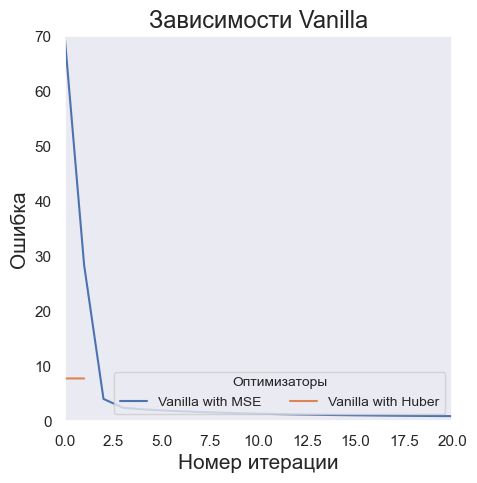

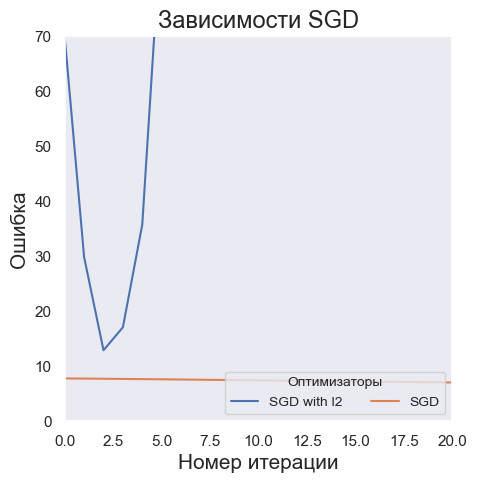

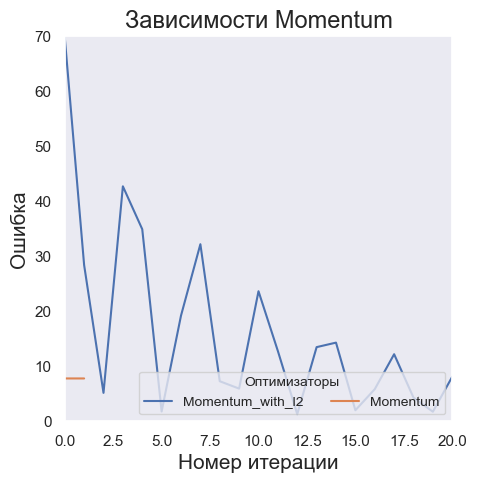

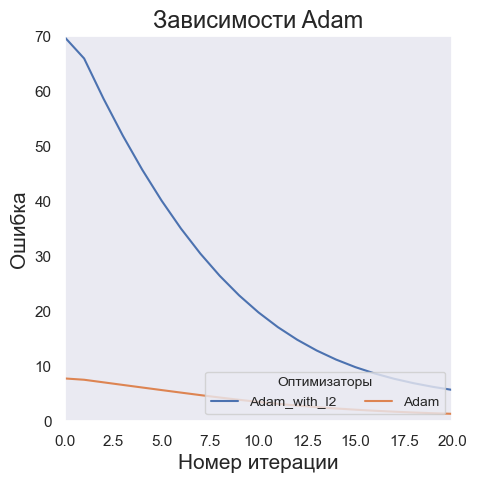

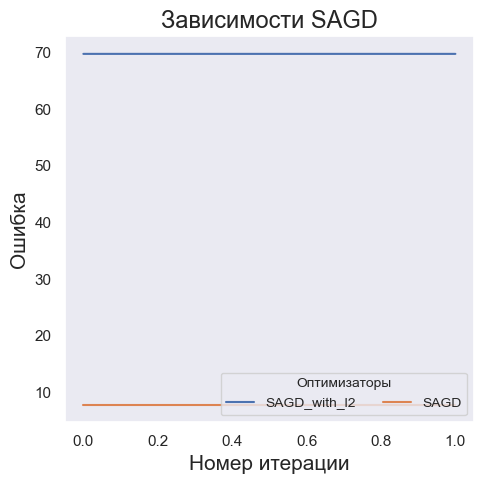

In [ ]:
plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 1)
plt.plot(Vanilla_history, label='Vanilla with MSE')
plt.plot(Vanilla_history2, label='Vanilla with Huber')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Vanilla', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 10))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()


plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 2)
plt.plot(SGD_history, label='SGD with l2')
plt.plot(SGD_history2, label='SGD')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости SGD', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 3)
plt.plot(Momentum_history, label='Momentum_with_l2')
plt.plot(Momentum_history2, label='Momentum')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Momentum', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 4)
plt.plot(Adam_history, label='Adam_with_l2')
plt.plot(Adam_history2, label='Adam')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Adam', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 5)
plt.plot(SAGD_history, label='SAGD_with_l2')
plt.plot(SAGD_history2, label='SAGD')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости SAGD', fontsize=17)
plt.xlabel('Номер итерации', fontsize=15)
plt.ylabel('Ошибка', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
#plt.xlim(0, 20)
#plt.ylim(0, 70)
plt.grid()


plt.tight_layout()
plt.show()

In [ ]:
# YOUR CODE
from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent)
#from linear_regression import LinearRegression, LossFunction
from sklearn.metrics import mean_squared_error, r2_score
lambda_arr= np.logspace(-9, -2, 4)
loss_storage_val=[]
Optimizers=[VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent]
k=0
for optim in Optimizers:
    lambda_1=bests_lambdas[k]
    optimizer = optim(lr_schedule=lambda: ConstantLR(lambda_1))
    model = LinearRegression(
            optimizer=optimizer,
            l2_coef=0.0,
            tolerance=1e-6,
            max_iter=2000,
            loss_function=LossFunction.LogCosh
        )
    model.fit(x_train,y_train)
    y_pred_val= model.predict(x_val)
    history=model.loss_history.copy()
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    loss_val=r2_score(y_val, y_pred_val)
    if k==0:
        Vanilla_history2=history
    elif k==1:
        SGD_history2=history
    elif k==2:
        Momentum_history2=history
    elif k==3:
        Adam_history2=history
    else:
        SAGD_history2=history
    k+=1

    print('Optimazer == '+str(optim)+' Best loss is '+str(loss_val))
    #bests_lambdas.append(best_lambda)
    #bests_losses.append(best_loss)

Optimazer == <class 'descents.VanillaGradientDescent'> Best loss is -55.724796276804035
Optimazer == <class 'descents.StochasticGradientDescent'> Best loss is -27.25942849658047
Optimazer == <class 'descents.MomentumDescent'> Best loss is -381.1901296144664
Optimazer == <class 'descents.Adam'> Best loss is -25.2969648339513
Optimazer == <class 'descents.SAGDescent'> Best loss is -55.321586999030266


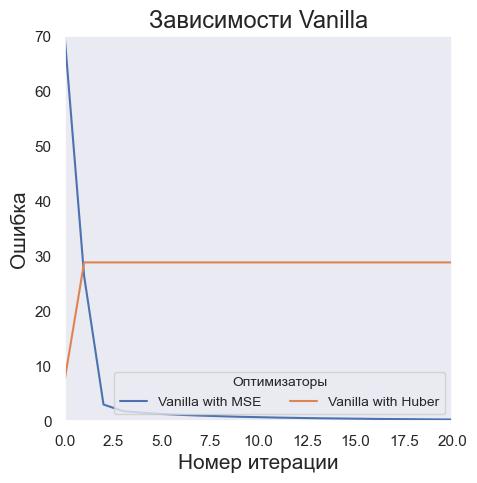

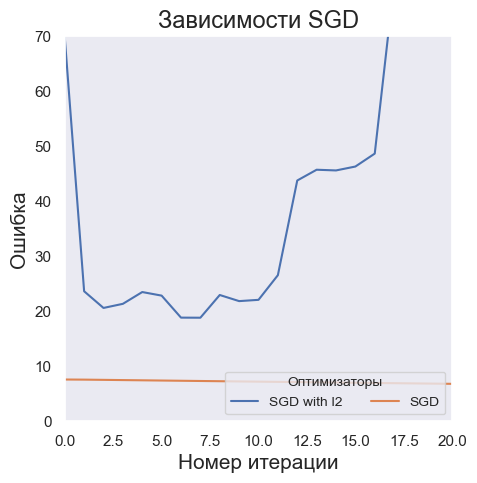

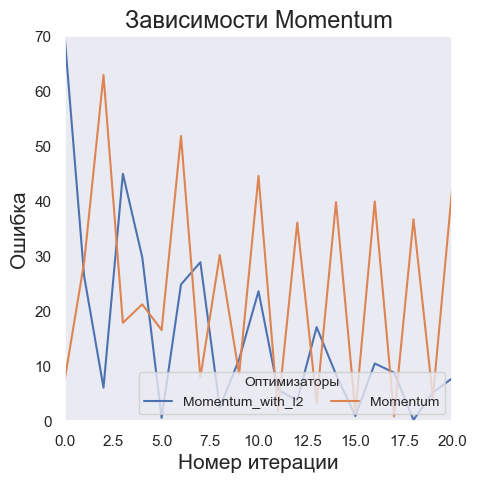

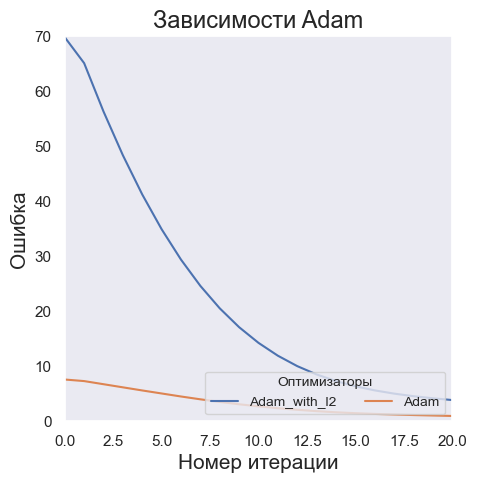

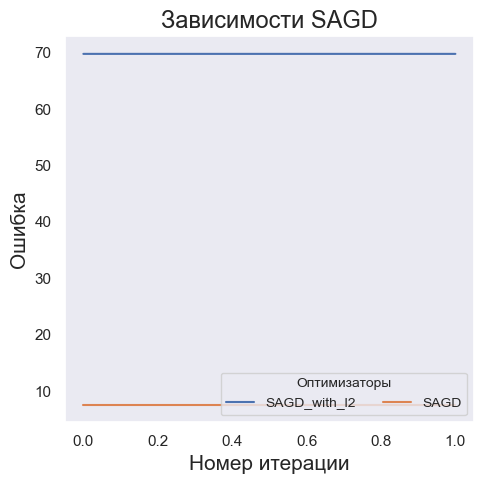

In [ ]:
plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 1)
plt.plot(Vanilla_history, label='Vanilla with MSE')
plt.plot(Vanilla_history2, label='Vanilla with Huber')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Vanilla', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 10))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()


plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 2)
plt.plot(SGD_history, label='SGD with l2')
plt.plot(SGD_history2, label='SGD')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости SGD', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 3)
plt.plot(Momentum_history, label='Momentum_with_l2')
plt.plot(Momentum_history2, label='Momentum')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Momentum', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 4)
plt.plot(Adam_history, label='Adam_with_l2')
plt.plot(Adam_history2, label='Adam')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости Adam', fontsize=17)
plt.ylabel('Ошибка', fontsize=15)
plt.xlabel('Номер итерации', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
plt.xlim(0, 20)
plt.ylim(0, 70)
plt.grid()

plt.figure(figsize = (5, 5))
#plt.subplot(2, 2, 5)
plt.plot(SAGD_history, label='SAGD_with_l2')
plt.plot(SAGD_history2, label='SAGD')
plt.legend(title='Оптимизаторы', title_fontsize=10, fontsize=10, ncol=2, loc='lower right')
plt.title('Зависимости SAGD', fontsize=17)
plt.xlabel('Номер итерации', fontsize=15)
plt.ylabel('Ошибка', fontsize=15)
#plt.yticks(np.arange(0, 1))
#plt.xticks(np.arange(0, 20))
#plt.xlim(0, 20)
#plt.ylim(0, 70)
plt.grid()


plt.tight_layout()
plt.show()

### Кулинарно-социализационный бонус. (0.5 балла)

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

### Бонус Бонусный со звездочкой. Рефакторинг LinearRegression с соблюдением OCP (0.5 балла)

Этот бонус для тех, у кого нет друзей и кулинарных способностей.

Цель - провести рефакторинг класса `LinearRegression`, руководствуясь принципом **Open-Closed Principle** (OCP). Напомним его суть: программные сущности (классы, модули, функции) должны быть открыты для расширения, но закрыты для модификации. В нашем контексте это означает, что добавление новой функции потерь или нового типа регуляризации не должно требовать внесения изменений в уже существующий код модели `LinearRegression` или оптимизаторов.

Вам предоставляется свобода в выборе конкретной реализации (например, через `Strategy`/`Protocol`/интерфейсы), однако итоговое решение должно удовлетворять перечисленным ниже требованиям.

**Требования к реализации**

**1. Совместимость с существующим кодом (жёсткие требования):**

* Публичный API класса `LinearRegression` должен остаться неизменным, чтобы не нарушать работу автоматических тестов.
* Аргумент конструктора `loss_function: LossFunction = LossFunction.MSE` и сам `Enum` `LossFunction` сохраняются.
* Имена/сигнатуры ключевых методов (`predict`, `compute_gradients`, `compute_loss`, `fit`) и полей (`w`, `loss_history`) должны остаться прежними.
* Должно работать динамическое переключение лосса через enum: присваивание
`model.loss_function = LossFunction.Huber` меняет поведение `compute_loss/compute_gradients` без пересоздания модели.
* Код оптимизаторов из `descents.py` не меняется и по-прежнему вызывает только `self.model.compute_gradients(...)`.

**2. Расширяемость архитектуры:**

* Необходимо реализовать возможность инъекции кастомной стратегии для функции потерь (например, через новый необязательный аргумент в конструкторе `loss=...`). При передаче такой стратегии она должна использоваться вместо той, что выбирается через `Enum`.
* Добавьте поддержку L2-регуляризации. Её реализация и способ интеграции остаются на ваше усмотрение. Решение о штрафовании свободного члена (`bias`) примите самостоятельно и кратко опишите в ноутбуке.


Для зачёта задания предоставьте в конце ноутбука отдельный раздел, в котором содержатся:

* Короткое описание (2–5 предложений), как решение следует OCP.
* Две мини-демонстрации:
    1.  Создание модели с `loss_function=LogCosh`, вызов `compute_loss`, последующее присваивание `model.loss_function = LossFunction.MSE` и повторный вызов `compute_loss`, показывающий, что поведение модели изменилось.
    2.  Создание модели с передачей вашей кастомной стратегии в конструктор и демонстрация того, что она корректно работает со стандартным оптимизатором (например, `Adam`).
* Подтверждение, что базовый сценарий (только `enum`, без кастомных стратегий) проходит ваши локальные проверки.